In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import os
import pickle
import yfinance as yf
import pandas_datareader as pdr
import tensorflow as tf
from tensorflow.keras import layers
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.preprocessing import OneHotEncoder

In [6]:
yf.pdr_override()
sp500 = pdr.get_data_yahoo('SPY', start='2016-01-04', end='2022-10-28')
sp500['return'] = np.log(sp500.Close/sp500.Close.shift(1))
sp500['cumreturn'] = sp500['return'].cumsum().apply(np.exp)
sp500.fillna(1, inplace=True)
sp500

,High,Low,Open,Close,Volume,Adj Close,return,cumreturn
Date,,,,,,,,
2016-01-04,201.029999,198.589996,200.490005,201.020004,222353500.0,178.051270,1.000000,1.000000
2016-01-05,201.899994,200.050003,201.399994,201.360001,110845800.0,178.352463,0.001690,1.001691
2016-01-06,200.059998,197.600006,198.339996,198.820007,152112600.0,176.102631,-0.012694,0.989056
2016-01-07,197.440002,193.589996,195.330002,194.050003,213436100.0,171.877655,-0.024284,0.965327
2016-01-08,195.850006,191.580002,195.190002,191.919998,209817200.0,169.991058,-0.011037,0.954731
...,...,...,...,...,...,...,...,...
2022-10-24,380.059998,373.109985,375.890015,378.869995,85436900.0,378.869995,0.012162,1.884738
2022-10-25,385.250000,378.670013,378.790009,384.920013,78846300.0,384.920013,0.015842,1.914834
2022-10-26,387.579987,381.350006,381.619995,382.019989,104087300.0,382.019989,-0.007563,1.900408


In [7]:
df = pd.read_csv(f"{os.path.dirname(os.getcwd())}\SP500 stock OHLC extended.csv", header=0, index_col=0, parse_dates=[0])
data = df.copy()
data = data.loc[data.index > '2004-08-11', ['Open', 'Close', 'symbol']]
data

,Open,Close,symbol
Date,,,
2004-08-12,15.579399,14.077253,A
2004-08-13,15.293276,14.678112,A
2004-08-16,14.556509,14.821173,A
2004-08-17,14.964235,15.157368,A
2004-08-18,15.193133,15.572246,A
...,...,...,...
2022-10-24,48.320000,49.779999,ZION
2022-10-25,47.720001,51.509998,ZION
2022-10-26,51.040001,50.400002,ZION


In [8]:
top50 = pd.read_csv(f"{os.path.dirname(os.getcwd())}\SP500_Top50_MarketCap.csv", header=0, index_col=0)
top50

,symbol
0,AAPL
1,MSFT
2,AMZN
3,GOOGL
4,BRK.B
...,...
498,FOX
499,DVA
500,DISH
501,VNO


In [9]:
contains_top50 = []
counter = 0
index = 0
while counter < 50 and index < len(top50):
    ticker = top50.iloc[index].symbol
    if ticker in data.symbol.unique():
        contains_top50.append(ticker)
        counter += 1
    index += 1
len(contains_top50)

50

In [10]:
data_top50 = data.loc[data.symbol.isin(contains_top50), :]
data_top50['log_close'] = np.log(data_top50.Close)
data_top50

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\2552074784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_top50['log_close'] = np.log(data_top50.Close)


,Open,Close,symbol,log_close
Date,,,,
2004-08-12,0.543750,0.542321,AAPL,-0.611897
2004-08-13,0.546429,0.550714,AAPL,-0.596540
2004-08-16,0.553571,0.549643,AAPL,-0.598486
2004-08-17,0.546071,0.551250,AAPL,-0.595567
2004-08-18,0.544821,0.566786,AAPL,-0.567773
...,...,...,...,...
2022-10-24,105.660004,106.599998,XOM,4.669083
2022-10-25,106.410004,105.879997,XOM,4.662306
2022-10-26,106.260002,107.139999,XOM,4.674136


In [11]:
top50_df = pd.DataFrame()
for ticker in data_top50.symbol.unique():
    temp = data_top50.loc[data_top50.symbol==ticker, :]
    temp = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2015-01-01')]
    top50_df.loc[:, f'{ticker}'] = temp.loc[:, 'log_close']
top50_df

,AAPL,ABT,ACN,ADBE,AMGN,AMZN,BAC,BMY,CMCSA,COP,...,T,TMO,TXN,UNH,UNP,UPS,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.122376,3.108716,3.272227,3.428975,4.163249,0.800206,3.838592,3.235930,2.393948,3.467585,...,2.961544,3.390473,3.185526,3.768384,2.824944,4.442651,3.594942,3.432535,3.976874,3.913821
2005-01-04,0.132594,3.098594,3.248435,3.402197,4.147253,0.745265,3.824721,3.224858,2.368061,3.461024,...,2.950937,3.377929,3.161247,3.758056,2.800326,4.429864,3.584764,3.433342,3.974434,3.907010
2005-01-05,0.141314,3.087056,3.244544,3.396687,4.131319,0.736446,3.813086,3.210440,2.377383,3.468417,...,2.955665,3.375196,3.130700,3.761549,2.791165,4.427836,3.583266,3.434471,3.975749,3.901771
2005-01-06,0.142089,3.109358,3.235536,3.379974,4.140592,0.719059,3.811539,3.208825,2.375836,3.482806,...,2.944200,3.375880,3.126761,3.783394,2.797281,4.426761,3.571452,3.438011,3.989910,3.914420
2005-01-07,0.212371,3.126344,3.281287,3.380654,4.142658,0.749527,3.800644,3.208421,2.384779,3.476462,...,2.941413,3.361070,3.132010,3.775401,2.785011,4.424847,3.567906,3.436725,3.988799,3.907814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,3.332294,3.822098,4.514370,4.314015,5.079353,2.718100,2.889260,4.080077,3.368502,4.250351,...,3.244526,4.842532,4.004784,4.631617,4.789989,4.722153,3.864302,4.013496,4.459335,4.540952
2014-12-26,3.349816,3.825375,4.513713,4.313078,5.096568,2.737900,2.889260,4.087320,3.373997,4.246779,...,3.250691,4.849449,4.002777,4.630351,4.790736,4.717874,3.868280,4.012411,4.464873,4.534855
2014-12-29,3.349114,3.819908,4.505571,4.305820,5.092830,2.747399,2.896464,4.091173,3.382354,4.250065,...,3.248933,4.843084,3.997466,4.628203,4.793308,4.722509,3.861782,4.020160,4.461762,4.533352


In [8]:
def weakly_stationary(ts, cutoff=0.05):
    ts = np.ravel(ts)
    return adfuller(ts)[1] < cutoff

In [9]:
def cointegration(ts1, ts2):
    return coint(ts1, ts2)[1]

In [ ]:
# cutoff = 0.05
# coint_dic = {}
# for i in range(50):
#     arr1 = top50_df.iloc[:, i].to_numpy()
#     for j in range(i+1, 50):
#         arr2 = top50_df.iloc[:, j].to_numpy()
#         p_value = cointegration(arr1, arr2)
#         if p_value < cutoff:
#             coint_dic[p_value] = (top50_df.columns[i], top50_df.columns[j])

In [ ]:
# with open('coint_dic.pkl', 'wb') as f:
#     pickle.dump(coint_dic, f)

In [12]:
with open('coint_dic.pkl', 'rb') as f:
    coint_dic = pickle.load(f)

In [13]:
p_values = list(map(lambda x: x, coint_dic.keys()))
p_values.sort()
bot10_pvalues = p_values[:10]
bot10_pvalues

[9.379459083057298e-06,
 3.034808466958149e-05,
 0.0001221161476226386,
 0.00038432690429147465,
 0.00048539846351391643,
 0.0005479432216908223,
 0.0007776209555745435,
 0.001618693748037122,
 0.0017420139945032945,
 0.0018933286061999983]

In [14]:
train_dic = {}
val_dic = {}
test_dic = {}
lag = 100
volatility = 0.5
sma_period = 30

for ele in bot10_pvalues:
    ticker1, ticker2 = coint_dic[ele]
    temp1= data_top50.loc[data_top50.symbol==ticker1, :]
    temp1.rename(columns={'Open': 'Open1',
                         'Close': 'Close1',
                         'symbol': 'symbol1',
                         'log_close': 'log_close1'}, inplace=True)
    temp2= data_top50.loc[data_top50.symbol==ticker2, :]
    temp2.rename(columns={'Open': 'Open2',
                         'Close': 'Close2',
                         'symbol': 'symbol2',
                         'log_close': 'log_close2'}, inplace=True)
    temp = temp1.merge(temp2, on='Date', how='left')
    temp.loc[:, 'spread'] = temp.log_close1 - temp.log_close2
    temp.loc[:, 'spread_shifted'] = temp.spread.shift(-7)
    temp.loc[:, 'diff_spread'] = temp.spread - temp.spread_shifted
    temp.loc[:, 'diff_spread_std_pos'] = temp.loc[temp.diff_spread > 0, 'diff_spread'].rolling(sma_period).std() * volatility
    temp.loc[:, 'diff_spread_std_neg'] = temp.loc[temp.diff_spread < 0, 'diff_spread'].rolling(sma_period).std() * volatility
    temp.loc[:, 'signal'] = np.where((temp.diff_spread > 0) & (temp.diff_spread > temp.diff_spread_std_pos), -1, 0)
    temp.loc[:, 'signal'] = np.where((temp.diff_spread < 0) & (temp.diff_spread < -temp.diff_spread_std_neg), 1, temp.signal)
    
    for i in range(1, lag):
        temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
    
    train = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2015-01-01'), :]
    val = temp.loc[(temp.index >= '2015-01-01') & (temp.index < '2016-01-01'), :]
    test = temp.loc[temp.index >= '2016-01-01', :]
    
    for df in [train, val, test]: 
        df.loc[:, 'Close1_shifted'] = df.Close1.shift(-6)
        df.loc[:, 'Close2_shifted'] = df.Close2.shift(-6)
        df.loc[:, 'Target1'] = ((df.Close1_shifted-df.Open1)/df.Open1).shift(-1)
        df.loc[:, 'Target2'] = ((df.Close2_shifted-df.Open2)/df.Open2).shift(-1)
        
    train_dic[(ticker1, ticker2)] = train
    val_dic[(ticker1, ticker2)] = val
    test_dic[(ticker1, ticker2)] = test

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.rename(columns={'Open': 'Open1',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.rename(columns={'Open': 'Open2',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.rename(columns={'Open': 'Open1',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.rename(columns={'Open': 'Open2',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close1_shifted'] = df.Close1.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close2_shifted'] = df.Close2.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.rename(columns={'Open': 'Open1',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.rename(columns={'Open': 'Open2',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close2_shifted'] = df.Close2.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Target1'] = ((df.Close1_shifted-df.Open1)/df.Open1).shift(-1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.rename(columns={'Open': 'Open2',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_19688\356037643.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [102]:
train_df = pd.concat(list(train_dic.values()))
train_df.loc[:, ['spread', 'spread_shifted', 'diff_spread', 'diff_spread_std_pos', 'diff_spread_std_neg', 'signal']]

,spread,spread_shifted,diff_spread,diff_spread_std_pos,diff_spread_std_neg,signal
Date,,,,,,
2005-01-03,-0.060693,-0.052682,-0.008011,NaN,0.009494,0
2005-01-04,-0.055261,-0.048142,-0.007119,NaN,0.009578,0
2005-01-05,-0.064502,-0.056127,-0.008375,NaN,0.009519,0
2005-01-06,-0.062252,-0.045678,-0.016574,NaN,0.009469,1
2005-01-07,-0.064062,-0.047882,-0.016180,NaN,0.009399,1
...,...,...,...,...,...,...
2014-12-24,-0.139383,-0.131969,-0.007413,NaN,0.005522,1
2014-12-26,-0.143713,-0.125278,-0.018436,NaN,0.005531,1
2014-12-29,-0.160483,-0.118180,-0.042303,NaN,0.005988,1


In [15]:
indicators = ['diff_spread']
for i in range(1, lag):
    indicators.append(f'diff_spread_{i}')

In [15]:
def get_dataset(key, dic, train_val = True):
    temp = dic[key]
    temp = temp.iloc[:-7, :] if train_val else temp
    x, y = temp.loc[:, indicators].to_numpy(), temp[['signal']].to_numpy()
    encoder = OneHotEncoder()
    y = encoder.fit_transform(y).todense()
    return x, y

In [16]:
x, y = get_dataset(('PEP', 'PG'), train_dic)
x.shape, y.shape

((2510, 100), (2510, 3))

In [17]:
def create_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=3)

In [18]:
def plot_history(histories):
    fig, ax = plt.subplots(10, 2, figsize=(150,150))
    fig.tight_layout()
    metrics = ['accuracy', 'loss']
    for i in range(10):
        history = histories[i]
        for j in range(2):
            metric = metrics[j]
            ax[i,j].plot(history.history[f'{metric}'])
            ax[i,j].plot(history.history[f'val_{metric}'])
            ax[i,j].legend([f'train {metric}', f'val {metric}'], loc='upper left')
            ax[i,j].set_title(f'cluster_{i}')
            ax[i,j].figure.set_size_inches(30,30)

In [103]:
# Train LSTM models for each cluster

histories = []
for pair in train_dic.keys():
    ticker1, ticker2 = pair
    train_x, train_y = get_dataset(pair, train_dic)
    val_x, val_y = get_dataset(pair, val_dic)
    
    tf.random.set_seed(0)
    inputs = layers.Input(shape=(100,), dtype=tf.float32)
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs)
    x = layers.LSTM(128, activation='relu', input_shape=(100,1))(x)
    output = layers.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, output)
    model.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])
    
    history = model.fit(train_x,
             train_y,
             epochs=15,
             validation_data=(val_x, val_y),
             callbacks = [create_early_stopping()])
    
    histories.append(history)
    file_loc = f'{os.getcwd()}\pair_{ticker1}_{ticker2}_pretrained_model'
    tf.keras.models.save_model(model, file_loc)

Epoch 1/15
79/79 [==============================] - 17s 188ms/step - loss: 1.0829 - accuracy: 0.3753 - val_loss: 1.0786 - val_accuracy: 0.4612
Epoch 2/15
79/79 [==============================] - 14s 176ms/step - loss: 1.0752 - accuracy: 0.3805 - val_loss: 1.0783 - val_accuracy: 0.4163
Epoch 3/15
79/79 [==============================] - 14s 174ms/step - loss: 1.0728 - accuracy: 0.3729 - val_loss: 1.0799 - val_accuracy: 0.2980
Epoch 4/15
79/79 [==============================] - 14s 174ms/step - loss: 1.0743 - accuracy: 0.3677 - val_loss: 1.0800 - val_accuracy: 0.2980
Epoch 5/15
79/79 [==============================] - 14s 175ms/step - loss: 1.0730 - accuracy: 0.3769 - val_loss: 1.0826 - val_accuracy: 0.2980
INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Cointegration_LSTM_strategy\pair_PEP_PG_pretrained_model\assets
Epoch 1/15
79/79 [==============================] - 17s 182ms/step - loss: 1.0806 - accuracy: 0.3873 - val_loss: 1.2286 - val_accuracy: 0.3633

Epoch 1/15
79/79 [==============================] - 24s 276ms/step - loss: 1.0799 - accuracy: 0.3892 - val_loss: 1.1297 - val_accuracy: 0.2898
Epoch 2/15
79/79 [==============================] - 21s 268ms/step - loss: 1.0714 - accuracy: 0.3876 - val_loss: 1.1319 - val_accuracy: 0.3184
Epoch 3/15
79/79 [==============================] - 22s 276ms/step - loss: 1.0708 - accuracy: 0.3972 - val_loss: 1.1408 - val_accuracy: 0.3224
Epoch 4/15
79/79 [==============================] - 21s 265ms/step - loss: 1.0698 - accuracy: 0.3972 - val_loss: 1.1582 - val_accuracy: 0.3102
INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Cointegration_LSTM_strategy\pair_MSFT_PEP_pretrained_model\assets
Epoch 1/15
79/79 [==============================] - 24s 275ms/step - loss: 1.0897 - accuracy: 0.3960 - val_loss: 1.0967 - val_accuracy: 0.4327
Epoch 2/15
79/79 [==============================] - 21s 269ms/step - loss: 1.0822 - accuracy: 0.3948 - val_loss: 1.0990 - val_accuracy: 0.43

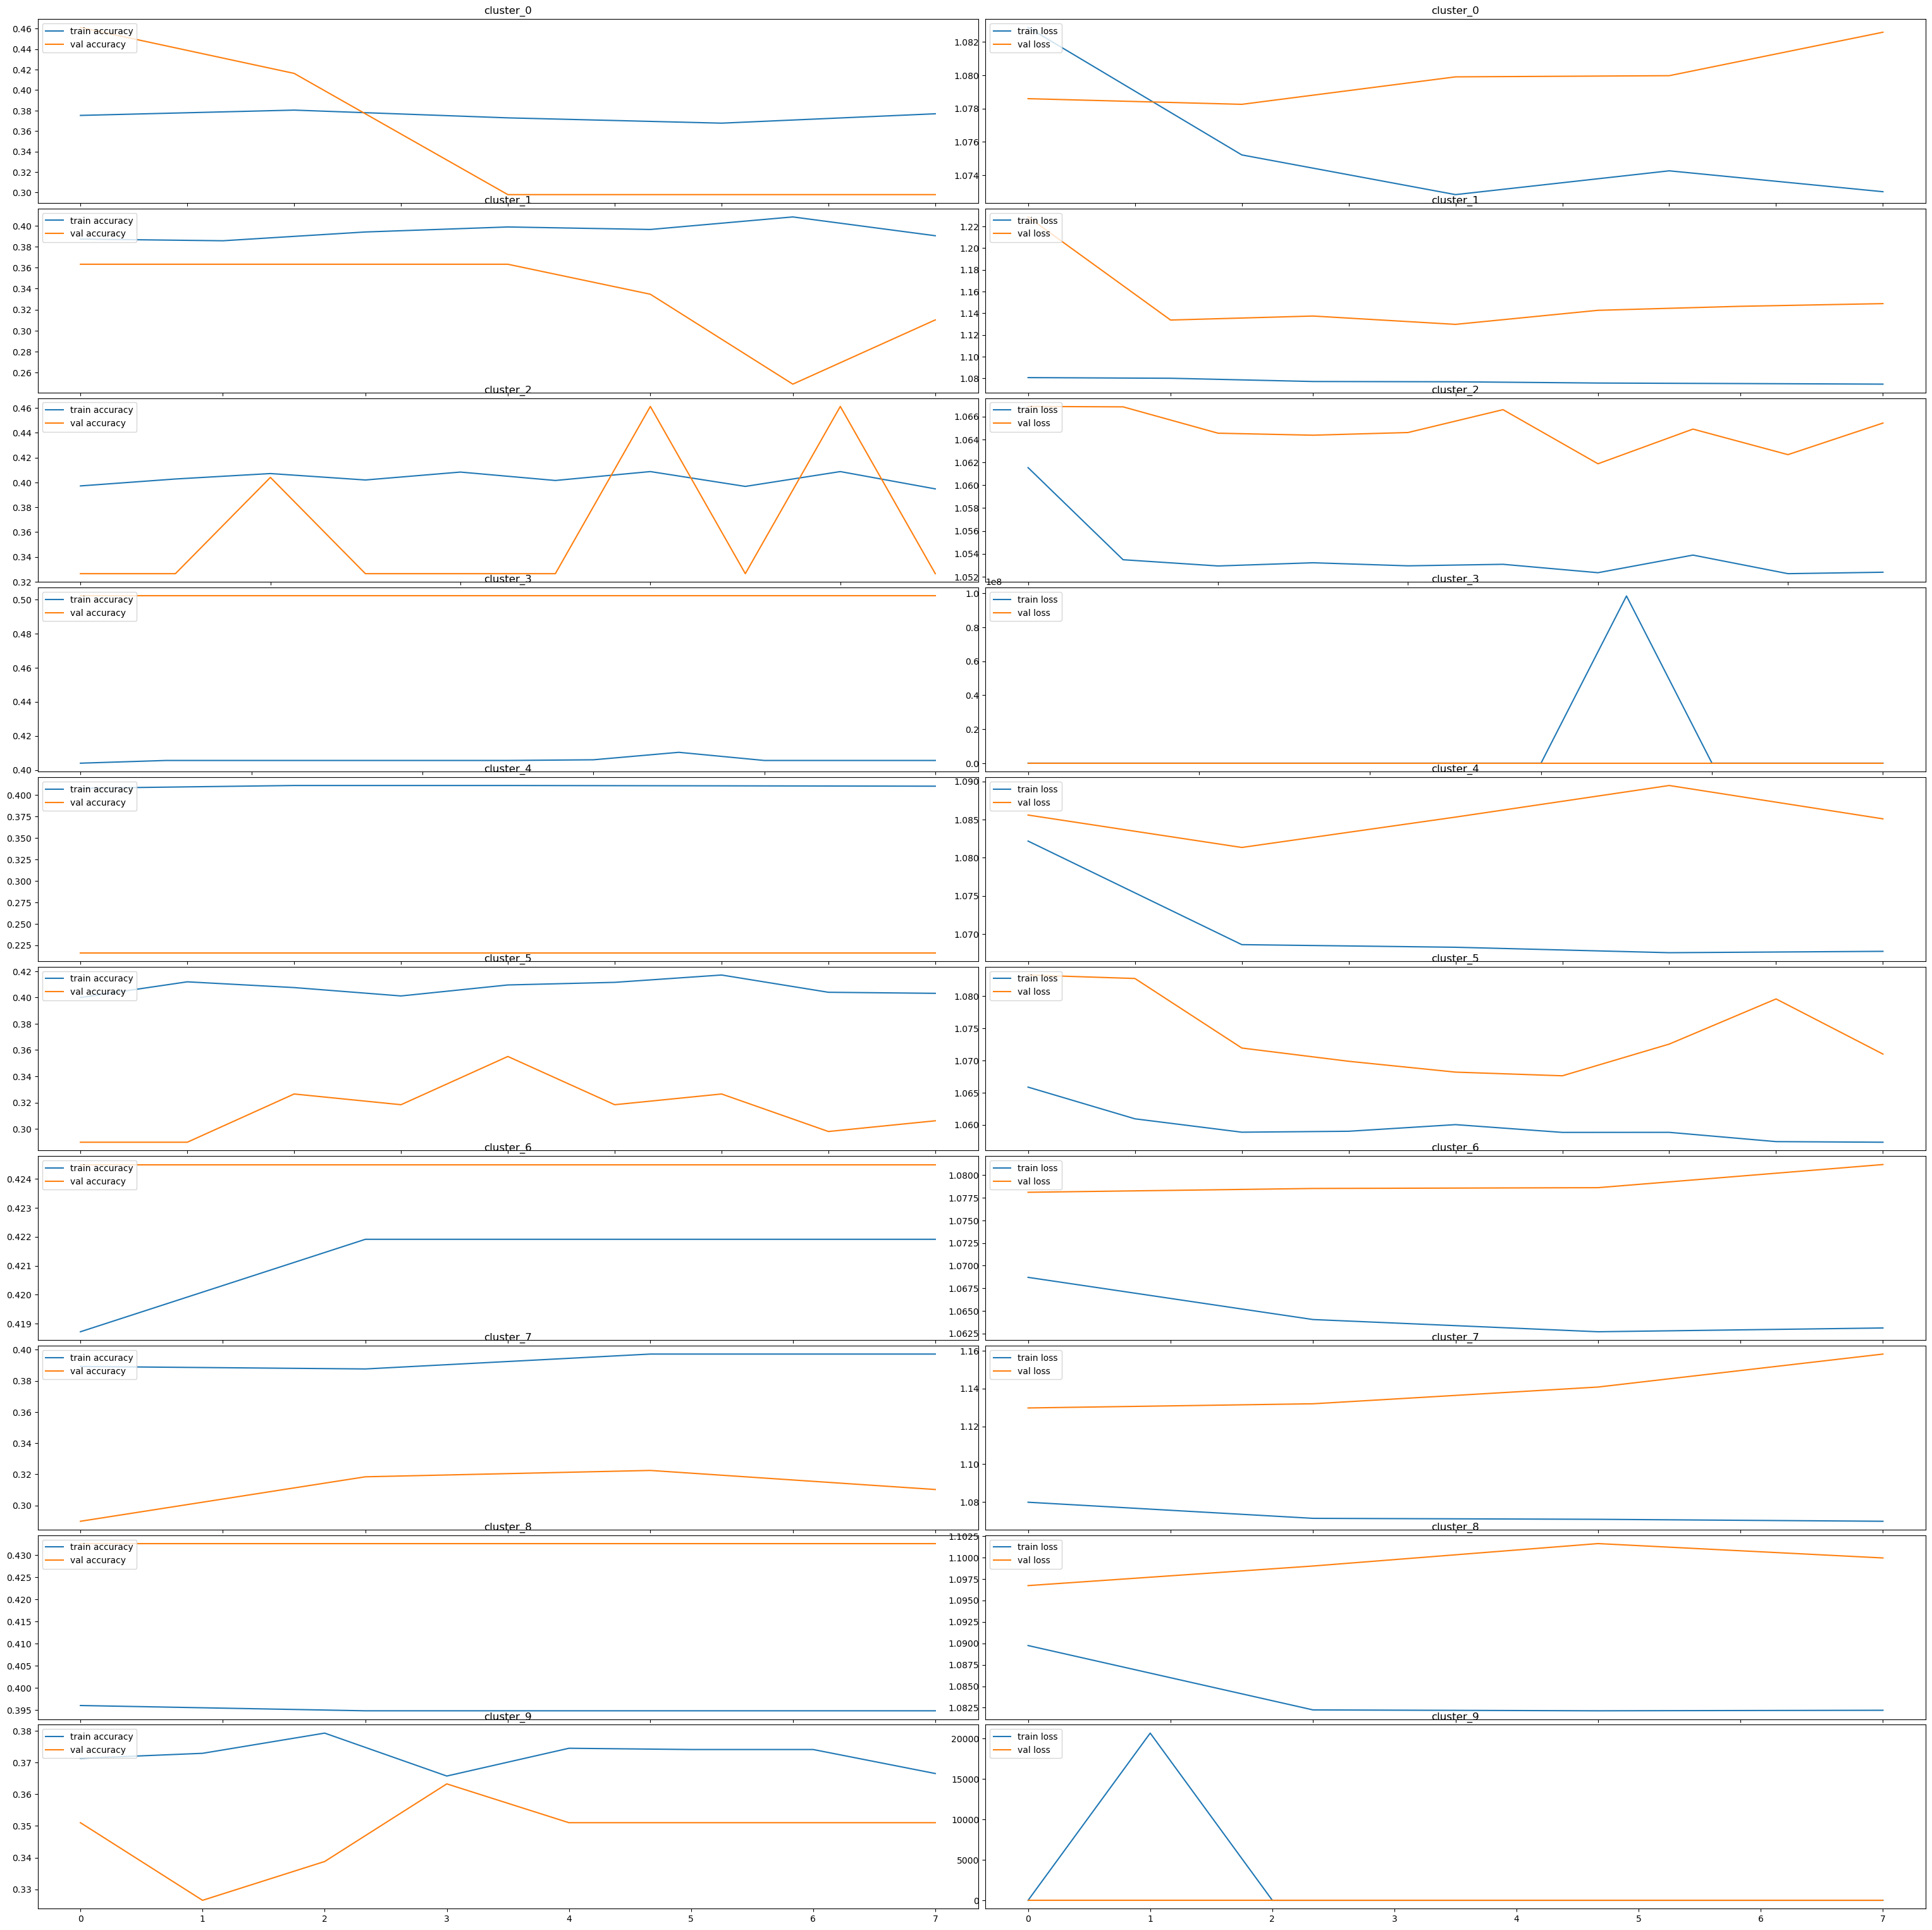

In [104]:
plot_history(histories)

In [105]:
fulltrain_dic = {}

for ele in bot10_pvalues:
    ticker1, ticker2 = coint_dic[ele]
    temp1= data_top50.loc[data_top50.symbol==ticker1, :]
    temp1.rename(columns={'Open': 'Open1',
                         'Close': 'Close1',
                         'symbol': 'symbol1',
                         'log_close': 'log_close1'}, inplace=True)
    temp2= data_top50.loc[data_top50.symbol==ticker2, :]
    temp2.rename(columns={'Open': 'Open2',
                         'Close': 'Close2',
                         'symbol': 'symbol2',
                         'log_close': 'log_close2'}, inplace=True)
    temp = temp1.merge(temp2, on='Date', how='left')
    temp.loc[:, 'spread'] = temp.log_close1 - temp.log_close2
    temp.loc[:, 'spread_shifted'] = temp.spread.shift(-7)
    temp.loc[:, 'diff_spread'] = temp.spread - temp.spread_shifted
    temp.loc[:, 'diff_spread_std_pos'] = temp.loc[temp.diff_spread > 0, 'diff_spread'].rolling(sma_period).std() * volatility
    temp.loc[:, 'diff_spread_std_neg'] = temp.loc[temp.diff_spread < 0, 'diff_spread'].rolling(sma_period).std() * volatility
    temp.loc[:, 'signal'] = np.where((temp.diff_spread > 0) & (temp.diff_spread > temp.diff_spread_std_pos), -1, 0)
    temp.loc[:, 'signal'] = np.where((temp.diff_spread < 0) & (temp.diff_spread < -temp.diff_spread_std_neg), 1, temp.signal)
    
    for i in range(1, lag):
        temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
    
    df = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2016-01-01'), :]
    
    df.loc[:, 'Close1_shifted'] = df.Close1.shift(-6)
    df.loc[:, 'Close2_shifted'] = df.Close2.shift(-6)
    df.loc[:, 'Target1'] = ((df.Close1_shifted-df.Open1)/df.Open1).shift(-1)
    df.loc[:, 'Target2'] = ((df.Close2_shifted-df.Open2)/df.Open2).shift(-1)
        
    fulltrain_dic[(ticker1, ticker2)] = df

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.rename(columns={'Open': 'Open1',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.rename(columns={'Open': 'Open2',
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close1_shifted'] = df.Close1.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close2_shifted'] = df.Close2.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Target1'] = ((df.Close1_shifted-df.Open1)/df.Open1).shift(-1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Target2'] = ((df.Close2_shifted-df.Open2)/df.Open2).shift(-1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close1_shifted'] = df.Close1.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close2_shifted'] = df.Close2.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp.loc[:, f'diff_spread_{i}'] = temp.diff_spread.shift(i)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2884672486.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [106]:
# Train LSTM models for each cluster

val_histories = []
epochs = [2, 5, 3, 4, 2, 6, 3, 5, 2, 5]
counter = 0

for pair in fulltrain_dic.keys():
    ticker1, ticker2 = pair
    train_x, train_y = get_dataset(pair, fulltrain_dic)
    
    tf.random.set_seed(0)
    inputs = layers.Input(shape=(100,), dtype=tf.float32)
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs)
    x = layers.LSTM(128, activation='relu', input_shape=(100,1))(x)
    output = layers.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, output)
    model.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])
    
    history = model.fit(train_x,
             train_y,
             epochs=epochs[counter])

    counter += 1
    
    val_histories.append(history)
    file_loc = f'{os.getcwd()}\pair_{ticker1}_{ticker2}_validated_model'
    tf.keras.models.save_model(model, file_loc)

Epoch 1/2
87/87 [==============================] - 24s 248ms/step - loss: 1.0808 - accuracy: 0.3885
Epoch 2/2
87/87 [==============================] - 23s 265ms/step - loss: 1.0754 - accuracy: 0.3903
INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Cointegration_LSTM_strategy\pair_PEP_PG_validated_model\assets
Epoch 1/5
87/87 [==============================] - 27s 281ms/step - loss: 1.0870 - accuracy: 0.3914
Epoch 2/5
87/87 [==============================] - 24s 271ms/step - loss: 1.0827 - accuracy: 0.3954
Epoch 3/5
87/87 [==============================] - 21s 236ms/step - loss: 1.0824 - accuracy: 0.3954
Epoch 4/5
87/87 [==============================] - 19s 222ms/step - loss: 1.0824 - accuracy: 0.3965
Epoch 5/5
87/87 [==============================] - 20s 231ms/step - loss: 1.0822 - accuracy: 0.3896
INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Cointegration_LSTM_strategy\pair_TXN_UPS_validated_model\assets
Epoch 1/3
87/87

In [107]:
x, y = get_dataset(('PEP', 'PG'), test_dic, False)
model = tf.keras.models.load_model(f'{os.getcwd()}\pair_PEP_PG_validated_model')
preds = model.predict(x)
preds

54/54 [==============================] - 6s 104ms/step


array([[0.36748752, 0.2555534 , 0.3769591 ],
       [0.36713803, 0.25591794, 0.37694398],
       [0.36693406, 0.256128  , 0.3769379 ],
       ...,
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan]], dtype=float32)

In [108]:
# Make predictions on test data

period = 7
preds = []
sample_df = test_dic[list(test_dic.keys())[0]]

for pair in test_dic.keys():
    ticker1, ticker2 = pair
    tf.keras.backend.clear_session()
    testx, _ = get_dataset(pair, test_dic, False)
    model = tf.keras.models.load_model(f'{os.getcwd()}\pair_{ticker1}_{ticker2}_validated_model')
    df = pd.DataFrame({'ticker1': [ticker1]*len(sample_df),
                      'ticker2': [ticker2]*len(sample_df),
                      'position': np.argmax(model.predict(testx), axis=1)-1})
    df.set_index(sample_df.index, inplace=True)
    preds.append(df)
preds_df = pd.concat(preds)
preds_df

54/54 [==============================] - 5s 82ms/step


,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,1
2016-01-06,PEP,PG,1
2016-01-07,PEP,PG,1
2016-01-08,PEP,PG,1
...,...,...,...
2022-10-24,MSFT,WFC,-1
2022-10-25,MSFT,WFC,-1
2022-10-26,MSFT,WFC,-1


In [109]:
preds_df.position.value_counts()

 1    14209
-1     2981
Name: position, dtype: int64

In [110]:
for i in range(len(preds_df.index.unique())):
    date = list(preds_df.index.unique())[i]
    if i%period != 0:
        preds_df.loc[preds_df.index == date, 'position'] = 0
preds_df

,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,0
2016-01-07,PEP,PG,0
2016-01-08,PEP,PG,0
...,...,...,...
2022-10-24,MSFT,WFC,0
2022-10-25,MSFT,WFC,-1
2022-10-26,MSFT,WFC,0


In [111]:
preds_df.position.value_counts()

 0    14730
 1     2040
-1      420
Name: position, dtype: int64

In [112]:
# preds_df.to_csv('preds.csv')

In [27]:
preds_df = pd.read_csv('preds.csv', header=0, index_col=0, parse_dates=[0])
preds_df

,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,0
2016-01-07,PEP,PG,0
2016-01-08,PEP,PG,0
...,...,...,...
2022-10-24,MSFT,WFC,0
2022-10-25,MSFT,WFC,-1
2022-10-26,MSFT,WFC,0


In [16]:
test_df = pd.concat(list(test_dic.values()))
test_df

,Open1,Close1,symbol1,log_close1,Open2,Close2,symbol2,log_close2,spread,spread_shifted,...,diff_spread_94,diff_spread_95,diff_spread_96,diff_spread_97,diff_spread_98,diff_spread_99,Close1_shifted,Close2_shifted,Target1,Target2
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,98.559998,98.769997,PEP,4.592794,78.360001,78.370003,PG,4.361441,0.231353,0.240785,...,0.016684,0.014035,0.013409,0.001583,-0.018644,-0.039522,97.620003,76.510002,-0.023378,-0.033019
2016-01-05,98.809998,99.449997,PEP,4.599655,78.440002,78.620003,PG,4.364626,0.235029,0.229662,...,0.008090,0.016684,0.014035,0.013409,0.001583,-0.018644,96.500000,75.849998,-0.026123,-0.019570
2016-01-06,98.379997,99.480003,PEP,4.599957,77.669998,77.860001,PG,4.354912,0.245044,0.225328,...,0.010684,0.008090,0.016684,0.014035,0.013409,0.001583,95.809998,76.150002,-0.046009,-0.024333
2016-01-07,98.459999,97.570000,PEP,4.580570,76.849998,77.180000,PG,4.346140,0.234430,0.221657,...,0.011715,0.010684,0.008090,0.016684,0.014035,0.013409,93.930000,74.980003,-0.021057,-0.008144
2016-01-08,97.830002,97.209999,PEP,4.576874,77.360001,75.970001,PG,4.330339,0.246535,0.212351,...,-0.005569,0.011715,0.010684,0.008090,0.016684,0.014035,95.769997,76.730003,-0.036676,-0.004464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,243.759995,247.250000,MSFT,5.510400,44.950001,45.200001,WFC,3.811097,1.699303,NaN,...,-0.047564,-0.060345,-0.082217,-0.101970,-0.080860,-0.025433,NaN,NaN,NaN,NaN
2022-10-25,247.259995,250.660004,MSFT,5.524097,44.779999,45.369999,WFC,3.814851,1.709246,NaN,...,-0.038178,-0.047564,-0.060345,-0.082217,-0.101970,-0.080860,NaN,NaN,NaN,NaN
2022-10-26,231.169998,231.320007,MSFT,5.443802,45.660000,45.700001,WFC,3.822098,1.621704,NaN,...,-0.094630,-0.038178,-0.047564,-0.060345,-0.082217,-0.101970,NaN,NaN,NaN,NaN


In [18]:
def get_pnl(x):
    if list(preds_df.index).index(x.index[0])%period == 0:
        return (x['position']*x['Target1']-x['position']*x['Target2']).sum()/x['position'].abs().sum() + 1
    return 1

In [29]:
def merge_preds(test_df, preds_df):
    temp = pd.concat([preds_df, test_df.loc[:, ['signal', 'Target1', 'Target2']]], axis=1)
    temp.set_index(test_df.index, inplace=True)
    return temp

In [20]:
def strategy_return(merged_preds_df):
    strategies = pd.DataFrame()
    strategies['avg return'] = merged_preds_df.groupby('Date').apply(get_pnl).shift(7).fillna(1)
    strategies['strategy'] = np.log(strategies['avg return'])
    strategies['cumstrategy'] = strategies['strategy'].cumsum().apply(np.exp)
    return strategies

In [30]:
test_preds = merge_preds(test_df, preds_df)
test_preds

,ticker1,ticker2,position,signal,Target1,Target2
Date,,,,,,
2016-01-04,PEP,PG,1,1,-0.023378,-0.033019
2016-01-05,PEP,PG,0,0,-0.026123,-0.019570
2016-01-06,PEP,PG,0,-1,-0.046009,-0.024333
2016-01-07,PEP,PG,0,-1,-0.021057,-0.008144
2016-01-08,PEP,PG,0,-1,-0.036676,-0.004464
...,...,...,...,...,...,...
2022-10-24,MSFT,WFC,0,0,NaN,NaN
2022-10-25,MSFT,WFC,-1,0,NaN,NaN
2022-10-26,MSFT,WFC,0,0,NaN,NaN


In [34]:
test_strategies = strategy_return(test_preds)
test_strategies

,avg return,strategy,cumstrategy
Date,,,
2016-01-04,1.00000,0.000000,1.000000
2016-01-05,1.00000,0.000000,1.000000
2016-01-06,1.00000,0.000000,1.000000
2016-01-07,1.00000,0.000000,1.000000
2016-01-08,1.00000,0.000000,1.000000
...,...,...,...
2022-10-24,1.00000,0.000000,1.668217
2022-10-25,1.00736,0.007333,1.680495
2022-10-26,1.00000,0.000000,1.680495


In [132]:
test_strategies.loc[test_strategies.index <= '2020-12-30', :]

,avg return,strategy,cumstrategy
Date,,,
2016-01-04,1.000000,0.000000,1.000000
2016-01-05,1.000000,0.000000,1.000000
2016-01-06,1.000000,0.000000,1.000000
2016-01-07,1.000000,0.000000,1.000000
2016-01-08,1.000000,0.000000,1.000000
...,...,...,...
2020-12-23,0.979435,-0.020779,1.520737
2020-12-24,1.000000,0.000000,1.520737
2020-12-28,1.000000,0.000000,1.520737


In [129]:
num_reset_days = 0
corr_preds = []

for i in range(len(list(test_strategies.index)[:-period])):
    if i%period == 0:
        date = list(test_strategies.index)[i]
        temp = test_preds.loc[test_preds.index == date, ['position', 'signal']]
        corr_preds.append(np.sum(np.where(temp.position == temp.signal, 1, 0)))
        num_reset_days += 1
        
hit_rate = np.sum(np.asarray(corr_preds))/(num_reset_days*10)
hit_rate

0.40244897959183673

In [36]:
for i in range(len(list(test_strategies.loc[test_strategies.index < '2021-01-01', :].index)[:-period])):
    if i%period == 0:
        date = list(test_strategies.index)[i]
        temp = test_preds.loc[test_preds.index == date, ['position', 'signal']]
        corr_preds.append(np.sum(np.where(temp.position == temp.signal, 1, 0)))
        num_reset_days += 1
        
hit_rate = np.sum(np.asarray(corr_preds))/(num_reset_days*10)
hit_rate

0.4094972067039106

In [82]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='SP500 Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend()

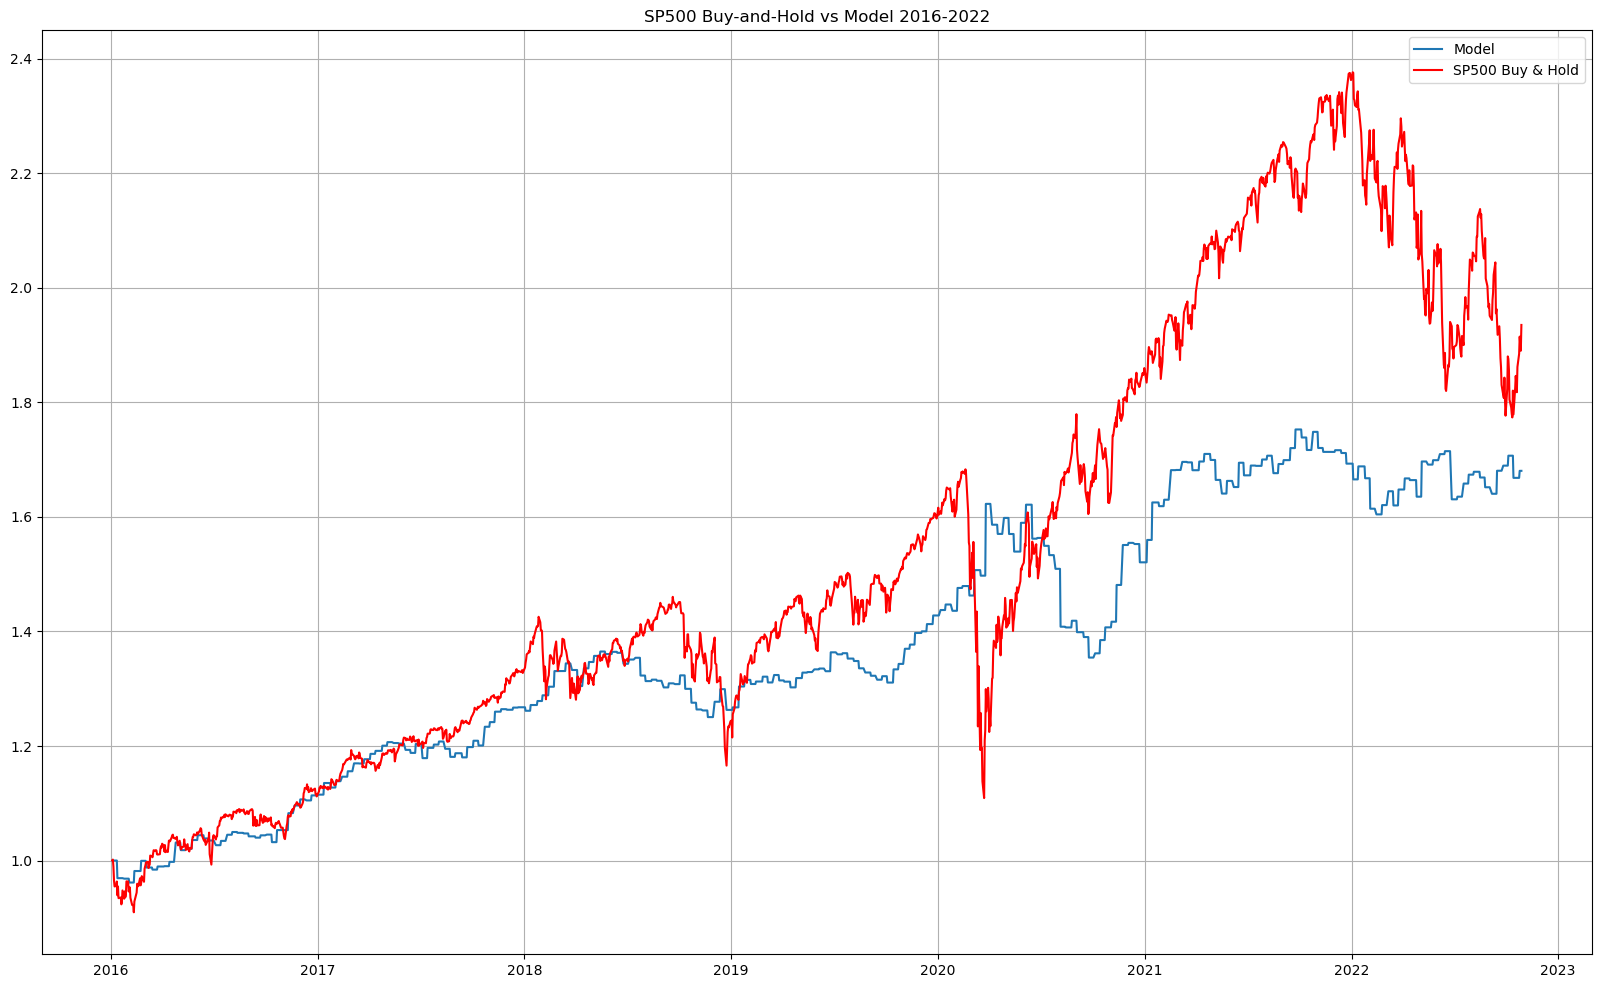

In [130]:
plot_returns(sp500, test_strategies, 'SP500 Buy-and-Hold vs Model 2016-2022')

In [119]:
sp500_weekly = sp500.copy()
sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-6)
sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%period == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target'])
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(7)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

0.13379370617302544

In [131]:
strategy_weekly_return = test_strategies.loc[test_strategies['avg return'] != 1, 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

0.1451754555057278

In [134]:
sp500_weekly = sp500.loc[sp500.index <= '2020-12-30', :]
sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-6)
sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%period == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target'])
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(7)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2488079470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_41288\2488079470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)


0.16723321200780666

In [133]:
strategy_weekly_return = test_strategies.loc[(test_strategies['avg return'] != 1) & (test_strategies.index <= '2020-12-30'), 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

0.16024098829258743